# Começando com o TensorFlow
O objetivo desse notebook é experimentar o **TensorFlow**, biblioteca de deep learning do **Google**.
Pré-requisitos:
- Saber programar em Python
- Conhecer um pouco de machine learning
- Conhecer um pouco de álgebra linear e cálculo

Para mais informações, acesse [a documentação do TensorFlow](https://www.tensorflow.org/get_started/get_started)

## Tensores
A unidade central do TensorFlow é o **tensor**. Um tensor nada mais é do que um conjunto de valores organizados num array de **N** dimensões. Exemplos:

In [30]:
import numpy as np
import tensorflow as tf
from graphviz import Digraph

t1 = np.array(3)                          # tensor de rank 0
t2 = np.array([1, 2, 3])                  # tensor de rank 1
t3 = np.array([[1, 2, 3], [4, 5, 6]])     # tensor de rank 2
t4 = np.array([[[1, 2, 3]], [[5, 6, 7]]]) # tensor de rank 3

In [5]:
t4.shape

(2, 1, 3)

## Grafos computacionais
Um programa no TensorFlow é construído em 2 etapas:
1. **Construindo** o grafo computacional;
2. **Rodando** o grafo computacional.

Um **grafo computacional** é uma série de operações no TensorFlow organizadas num grafo de nós ou vértices. <br/>
Cada **nó ou vértice** recebe de zero a N tensores como **input**, e um tensor como **output**. <br/>
Um vértice constante não recebe nenhum input, e produz como output um valor constante guardado internamente:

In [11]:
vertice1 = tf.constant(2., dtype=tf.float32)
vertice2 = tf.constant(3.)    # implicitamente tf.float32
print(vertice1, vertice2)

Tensor("Const_8:0", shape=(), dtype=float32) Tensor("Const_9:0", shape=(), dtype=float32)


Ao imprimir os vértices, não vemos ``2.0`` e ``3.0``. Vemos os vértices. <br/>
Para vermos os valores, precisamos **rodar o gráfo computacional** dentro de uma **sessão**:

In [12]:
sessao = tf.Session()
print(sessao.run([vertice1, vertice2]))

[2.0, 3.0]


Podemos calcular operações mais complexas combinando **vértices** com operações. Operações **também** são **vértices**. <br/>
Por exemplo, adicionando os dois vértices constantes produzimos um novo grafo:

In [13]:
vertice3 = tf.add(vertice1, vertice2)
print('vertice3: ', vertice3)
print('sessan.run(vertice3): ', sessao.run(vertice3))

vertice3:  Tensor("Add:0", shape=(), dtype=float32)
sessan.run(vertice3):  5.0


Vértices constantes não são muito interessantes. Um grafo pode ser parametrizado para aceitar inputs externos, chamados de **placeholders**. <br/>
Um **placeholder** é uma promessa de prover um valor mais tarde:

In [15]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
soma = a + b   # a mesma coisa que tf.add(a, b)

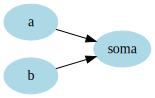

In [49]:
gc = Digraph()
gc.attr(rankdir='LR'); gc.node_attr.update(color='lightblue', style='filled')
gc.edge('a', 'soma')
gc.edge('b', 'soma')
gc

As linhas acima são **como uma função**, que **recebe dois tensores como input**, e **produz um tensor como output** sendo a soma dos inputs. <br/>
Para passarmos os inputs, ao rodar o grafo, usamos o parâmetro **feed_dict**:

In [18]:
print(sessao.run(soma, feed_dict={a: 4, b: 2.5}))
print(sessao.run(soma, feed_dict={a: [3, 6], b: [1, -4]}))

6.5
[ 4.  2.]


Podemos aumentar a complexidade do grafo adicionando operações:

In [52]:
soma_e_mult = soma * 4.
print(sessao.run(soma_e_mult, {a: [3, -1, 5], b: [6, 2, 6]}))

[ 36.   4.  44.]


Em machine learning, para que os modelos sejam treináveis, precisamos modificar os grafos para que obtenhamos outputs diferentes a partir de um mesmo input (que minimize uma função de erro). <br/>
Para isso, usamos **variáveis**: elas nos permitem adicionar parâmetros treináveis nos grafos:

In [53]:
x = tf.placeholder(tf.float32)
W = tf.Variable([.5], dtype=tf.float32)
b = tf.Variable([-.5], dtype=tf.float32)
modelo_linear = W * x + b

Diferente das constantes, que são inicializadas na sua criação e nunca mudam, as variáveis precisam ser **inicializadas**:

In [54]:
init = tf.global_variables_initializer()
sessao.run(init)

Como **x** é um **placeholder**, podemos avaliar o modelo linear que criamos para vários valores de **x ao mesmo tempo**:

In [56]:
print(sessao.run(modelo_linear, {x: [1, 2, 3, 4]}))

[ 0.   0.5  1.   1.5]


Criamos o modelo, mas não sabemos o quão bom ele é. Para avaliarmos o modelo, precisamos de um **placeholder y** para entrar com os valores desejados, e de uma **função de erro (loss function)** que será minimizada.

A função de erro serve para nos dizer o quão longe o nosso modelo está dos dados fornecidos, ou seja, da realidade. A forma mais utilizada em regressões lineares é a função que calcula a raiz quadrada da soma entre os deltas do modelo e dos dados fornecidos. **``modelo_linear - y``** criará um vetor onde cada elemento será o delta. **``tf.square``** calculará a raiz quadrada. **``tf.reduce_sum``** somará todos os deltas num valor escalar único, que indicará o erro a ser minimizado:

In [57]:
y = tf.placeholder(tf.float32)
raiz_deltas = tf.square(modelo_linear - y)
erro = tf.reduce_sum(raiz_deltas)
print(sessao.run(erro, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

31.5


## Treinando o modelo e minimizando o erro
Precisamos encontrar **W** e **b** que minimizam o erro, para que nosso modelo represente bem a realidade. Para isso, usaremos **otimizadores** do TensorFlow, que mudam cada variável passo-a-passo em busca de **minimizar a função de erro, ou loss function**. <br/>
O otimizador mais simples é o **método do gradiente, ou gradient descent**, que modifica cada variável de acordo com a magnitude da derivada do erro com respeito àquela variável:

In [59]:
otimizador = tf.train.GradientDescentOptimizer(0.01)
treino = otimizador.minimize(erro)

sessao.run(init)
for i in range(1000):
    sessao.run(treino, {x: [1, 2, 3, 4], y: [0, -5, -10, -15]})
    
print(sessao.run([W, b]))

[array([-4.99998665], dtype=float32), array([ 4.99995995], dtype=float32)]


## O programa completo

In [62]:
import tensorflow as tf

# Inicializando os placeholders do modelo
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# Inicializando as variáveis que queremos determinar
W = tf.Variable([.1], dtype=tf.float32)
b = tf.Variable([.1], dtype=tf.float32)

# Inicializando o modelo linear
modelo_linear = W * x + b

# Inicializando o otimizador e o erro
raiz_deltas = tf.square(modelo_linear - y)
erro = tf.reduce_sum(raiz_deltas)
otimizador = tf.train.GradientDescentOptimizer(0.01)
treino = otimizador.minimize(erro)

# Entrando com os dados para treinamento do modelo
x_treino = [1, 2, 3, 4]
y_treino = [0, -5, -10, -15]
iteracoes = 1000

# Inicializando o TensorFlow
init = tf.global_variables_initializer()
sessao = tf.Session()
sessao.run(init)

# Treinando o modelo
for i in range(iteracoes):
    sessao.run(treino, {x: x_treino, y: y_treino})

# Imprimindo os resultados
W_final, b_final, erro_final = sessao.run([W, b, erro], {x: x_treino, y: y_treino})

print('W: %f  |  b: %f  |  erro: %f' % (W_final, b_final, erro_final))

W: -4.999988  |  b: 4.999964  |  erro: 0.000000


## tf.estimator
Essa biblioteca do TensorFlow simplifica o código que escrevemos para o machine learning. Ela ajuda a:
- rodar loops de treinamento
- rodar loops de avaliação
- manipular datasets

O modelo linear fica mais simples ao utilizarmos essa biblioteca:

In [65]:
import tensorflow as tf
import numpy as np

feature_columns = [tf.feature_column.numeric_column('x', shape=[1])]

estimator = tf.estimator.LinearRegressor(feature_columns=feature_columns)

x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0])

input_fn = tf.estimator.inputs.numpy_input_fn({'x': x_train}, y_train, batch_size=4, num_epochs=None, shuffle=True)
train_input_fn = tf.estimator.inputs.numpy_input_fn({'x': x_train}, y_train, batch_size=4, num_epochs=1000, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn({'x': x_eval}, y_eval, batch_size=4, num_epochs=1000, shuffle=False)

estimator.train(input_fn=input_fn, steps=1000)

train_metrics = estimator.evaluate(train_input_fn)
eval_metrics = estimator.evaluate(eval_input_fn)

print('train metrics: %r' % train_metrics)
print('eval metrics: %r' % eval_metrics)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_model_dir': '/var/folders/qb/ft804ytj60d37r560fhfyxhw0000gn/T/tmpg1sh5rgh', '_session_config': None, '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/qb/ft804ytj60d37r560fhfyxhw0000gn/T/tmpg1sh5rgh/model.ckpt.
INFO:tensorflow:loss = 23.0, step = 1
INFO:tensorflow:global_step/sec: 1246.46
INFO:tensorflow:loss = 0.174449, step = 101 (0.081 sec)
INFO:tensorflow:global_step/sec: 1400.21
INFO:tensorflow:loss = 0.031354, step = 201 (0.071 sec)
INFO:tensorflow:global_step/sec: 1446.72
INFO:tensorflow:loss = 0.0257966, step = 301 (0.069 sec)
INFO:tensorflow:global_step/sec: 1440.47
INFO:tensorflow:loss = 0.00163111, step = 401 (0.069 sec)
INFO:tensorflow:global_s

## Construindo um modelo customizado usando tf.estimator

In [66]:
import numpy as np
import tensorflow as tf

# Declare list of features, we only have one real-valued feature
def model_fn(features, labels, mode):
  # Build a linear model and predict values
  W = tf.get_variable("W", [1], dtype=tf.float64)
  b = tf.get_variable("b", [1], dtype=tf.float64)
  y = W * features['x'] + b
  # Loss sub-graph
  loss = tf.reduce_sum(tf.square(y - labels))
  # Training sub-graph
  global_step = tf.train.get_global_step()
  optimizer = tf.train.GradientDescentOptimizer(0.01)
  train = tf.group(optimizer.minimize(loss),
                   tf.assign_add(global_step, 1))
  # EstimatorSpec connects subgraphs we built to the
  # appropriate functionality.
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=y,
      loss=loss,
      train_op=train)

estimator = tf.estimator.Estimator(model_fn=model_fn)
# define our data sets
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=None, shuffle=True)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=1000, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_eval}, y_eval, batch_size=4, num_epochs=1000, shuffle=False)

# train
estimator.train(input_fn=input_fn, steps=1000)
# Here we evaluate how well our model did.
train_metrics = estimator.evaluate(input_fn=train_input_fn)
eval_metrics = estimator.evaluate(input_fn=eval_input_fn)
print("train metrics: %r"% train_metrics)
print("eval metrics: %r"% eval_metrics)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_model_dir': '/var/folders/qb/ft804ytj60d37r560fhfyxhw0000gn/T/tmpw2z_cfsw', '_session_config': None, '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/qb/ft804ytj60d37r560fhfyxhw0000gn/T/tmpw2z_cfsw/model.ckpt.
INFO:tensorflow:loss = 5.31238924081, step = 1
INFO:tensorflow:global_step/sec: 1548.4
INFO:tensorflow:loss = 0.0391108623444, step = 101 (0.067 sec)
INFO:tensorflow:global_step/sec: 1597.67
INFO:tensorflow:loss = 0.00322069950067, step = 201 (0.062 sec)
INFO:tensorflow:global_step/sec: 1577.46
INFO:tensorflow:loss = 0.000274839182001, step = 301 (0.064 sec)
INFO:tensorflow:global_step/sec: 1605.8
INFO:tensorflow:loss = 1.41812130956e-05, step = 401